<a href="https://colab.research.google.com/github/cerasole/EnvironmentalRadioactivity/blob/main/Notebooks/SpectralFitHPGe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-Purity Germanium (HPGe)

In questo notebook analizziamo i dati presi in alcune acquisizioni di spettroscopia effettuate con un rivelatore a germanio.

Scaricheremo 1 file di testo contenente il tempo di acquisizione ove sta scritto "$MEAS_TIM" ed i valori dell'istogramma in ADC dei conteggi osservati.


In [1]:
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/HPGe/fondo_open.Spe

--2025-03-05 17:49:24--  https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/HPGe/fondo_open.Spe
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164264 (160K) [text/plain]
Saving to: ‘fondo_open.Spe’

fondo_open.Spe      100%[===================>] 160.41K  --.-KB/s    in 0.02s   

2025-03-05 17:49:24 (7.28 MB/s) - ‘fondo_open.Spe’ saved [164264/164264]



In [2]:
!pip install iminuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 7.3 MB/s eta 0:00:00


In [3]:
# General libreries
import os, glob
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size = 16)

# Fit
from iminuit import Minuit
from iminuit.cost import LeastSquares

files = glob.glob("*.Spe")
print("File a disposizione:", files)

class Acq ():

    def __init__(self, filename = None):
        self.filename = filename
        self.adc = None
        self.energy = None
        self.counts, self.counts_err = None, None
        self.time = None
        if filename is not None:
            self.read()
        return

    def read(self):
        self.counts = np.loadtxt(self.filename, unpack = True, skiprows = 12, max_rows = 8191)
        self.adc = np.arange(len(self.counts))
        self.bin_edges = np.arange(-0.5, len(self.counts)+0.5, 1)
        self.time = np.loadtxt(self.filename, skiprows = 9, max_rows = 1)[1]
        self.counts_err = np.sqrt(self.counts)
        self.rate = self.counts / self.time
        self.rate_err = self.counts_err / self.time
        return

File a disposizione: ['fondo_open.Spe']


In [4]:
data = Acq("fondo_open.Spe")

In [ ]:
data.counts

array([0., 0., 0., ..., 8., 6., 4.])

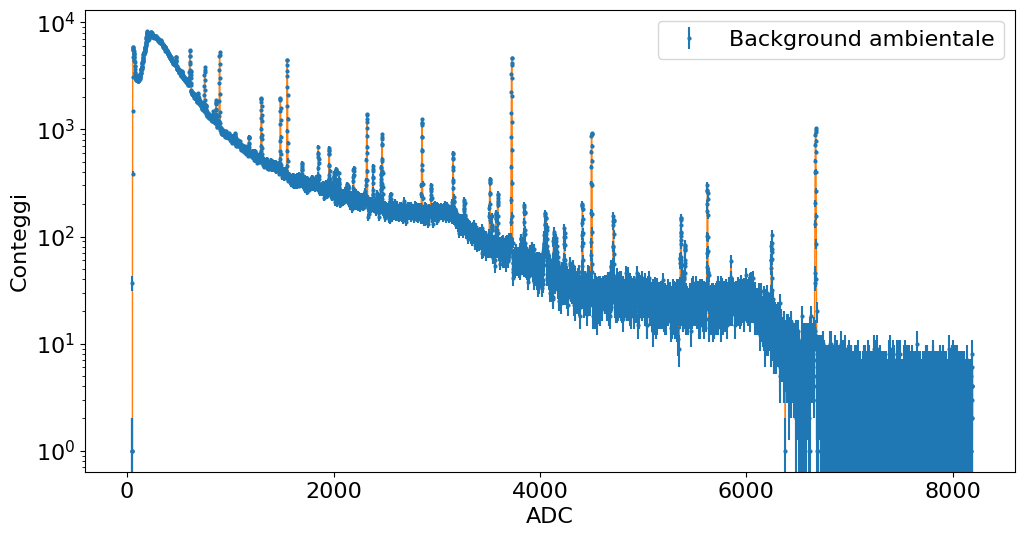

In [5]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.adc, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, data.bin_edges)
ax.set_yscale("log")
ax.set_xlabel("ADC")
ax.set_ylabel("Conteggi")
ax.legend();

(850.0, 910.0)

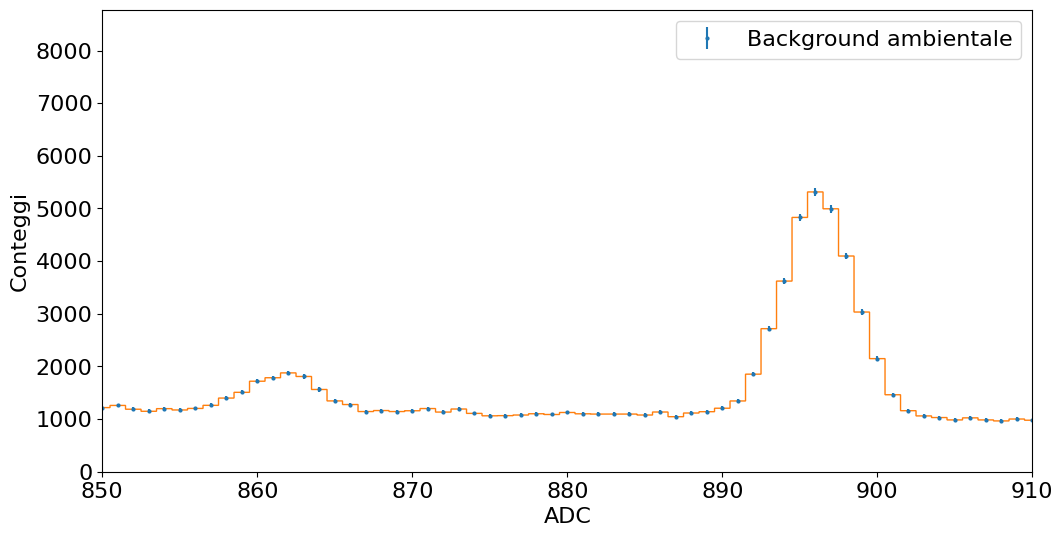

In [19]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.adc, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, data.bin_edges)
#ax.set_yscale("log")
ax.set_xlabel("ADC")
ax.set_ylabel("Conteggi")
ax.legend()
ax.set_xlim(850, 910)

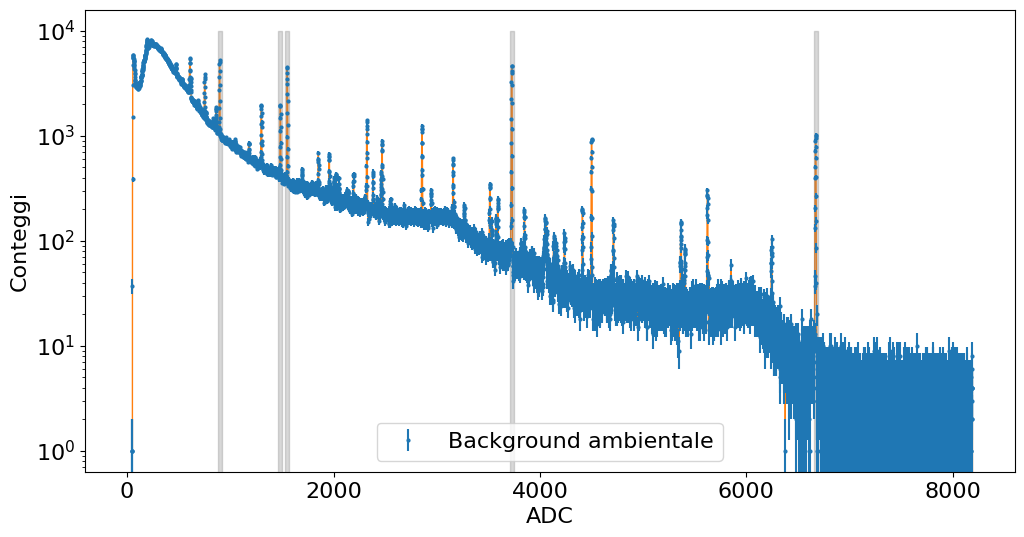

In [29]:
adc_peaks = np.array([897, 1484, 1552, 3727, 6671], dtype = np.float64)
energy_peaks = np.array([351.9, 583, 609.3, 1460, 2614.7])
adc_peaks_err = np.array([2, 2, 2, 2, 2], dtype = np.float64)

fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.adc, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, data.bin_edges)
ax.set_yscale("log")
ax.set_xlabel("ADC")
ax.set_ylabel("Conteggi")
ax.legend();

for i in range(len(adc_peaks)):
  ax.fill_between(
      y1 = [10000, 10000],
      y2 = [0, 0],
      x = [adc_peaks[i] - 10*adc_peaks_err[i], adc_peaks[i] + 10*adc_peaks_err[i]],
          color = "gray", alpha = 0.3)

In [21]:
def gaus (x, A, mu, sigma):
  return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def pol1 (x, p0, p1):
  return p0 + p1*x

def gaus_pol1 (x, A, mu, sigma, p0, p1):
  return gaus (x, A, mu, sigma) + pol1 (x, p0, p1)

def fit_peak (data, energy, adc, adc_err):
  print (f" - Peak with energy {energy:.0f} keV")
  x1, x2 = adc - 10*adc_err, adc + 10 * adc_err
  mask = (data.adc >= x1 ) * (data.adc <= x2)

  lsq = LeastSquares(x = data.adc[mask], y = data.counts[mask], yerror = data.counts_err[mask], model = gaus_pol1)
  m = Minuit(lsq, A = 1, mu = adc_peaks[i], sigma = adc_peaks_err[i], p0 = 1., p1 = -1.)
  m.limits["sigma"] = (0.1, 0.01*energy)
  m.limits["mu"] = (adc - adc_err, adc + adc_err)
  m.migrad()
  m.hesse()
  print (m)

  # Plot
  fig, axs = plt.subplots(2, 1, figsize = (6, 7), sharex = True, gridspec_kw={"height_ratios":[3., 1.]})
  fig.subplots_adjust(hspace = 0)

  ax = axs[0]
  ax.errorbar(x = data.adc[mask], y = data.counts[mask], xerr = np.diff(data.adc)[0]/2, yerr = data.counts_err[mask], ls = "None", marker = "o", ms = 4)
  ax.set_xlabel("ADC")
  ax.set_ylabel("Conteggi")
  ax.grid(which = "both")
  ax.set_yscale("log")
  ax.set_title(f"Peak with energy {energy_peaks[i]:.0f} keV")
  ax.set_ylim(bottom = max(0.2, 0.5*np.min(data.counts[mask] - data.counts_err[mask])), top = 1.3*np.max(data.counts[mask] - data.counts_err[mask]))

  x = np.linspace(x1, x2, 200)
  y = gaus_pol1(x, *m.values)
  y_gaus = gaus(x, *m.values[:3])
  y_pol1 = pol1(x, *m.values[3:])

  ax.plot(x, y, label = "Fit")
  ax.plot(x, y_gaus, label = "Gaussian")
  ax.plot(x, y_pol1, label = "Polynomial")
  ax.legend(fontsize = "small")

  ax = axs[1]
  residui =  (data.counts[mask] - gaus_pol1(data.adc[mask], *m.values)) / data.counts_err[mask]
  ax.errorbar(
      x = data.adc[mask],
      y = residui,
      xerr = np.diff(data.adc)[0]/2,
      yerr = 0,
      ls = "None",
      marker = "o",
      ms = 4,
  )
  ax.set_yticks([-3, 0, 3])
  ax.grid()
  ax.set_xlabel("ADC")
  ax.set_ylabel("Residuals")

  #fig2, ax2 = plt.subplots(figsize = (6, 5))
  #ax2.hist(residui, bins = int(len(residui)/6))
  #ax2.set_xlabel("Residuals")
  #ax2.set_ylabel("Counts")

  chi_reduced = m.fval / m.ndof
  print (f" Chi square / ndof of the fit is {m.fval:.2f} / {m.ndof} = {chi_reduced:.2f}")
  print (f" Corresponding ADC value is {m.values['mu']:.2f} +/- { m.errors['mu']:.2f}")
  return m.values["mu"], m.errors["mu"]

 - Peak with energy 352 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.39 (χ²/ndof = 0.8)      │              Nfcn = 346              │
│ EDM = 2.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

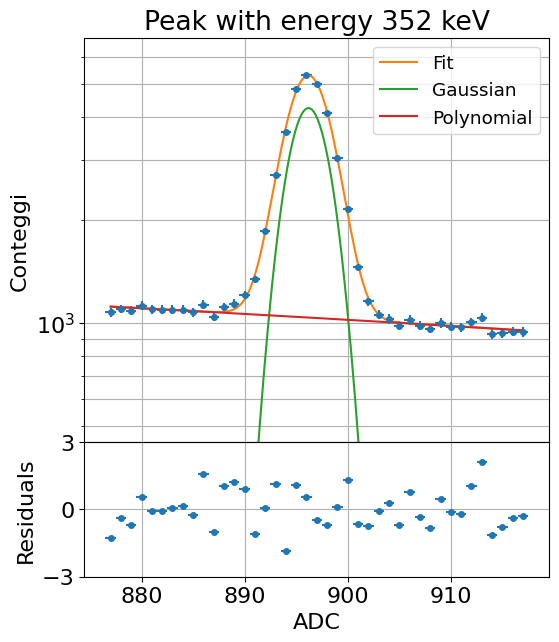

In [30]:
i = 0
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 583 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.48 (χ²/ndof = 1.1)      │              Nfcn = 344              │
│ EDM = 2.56e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

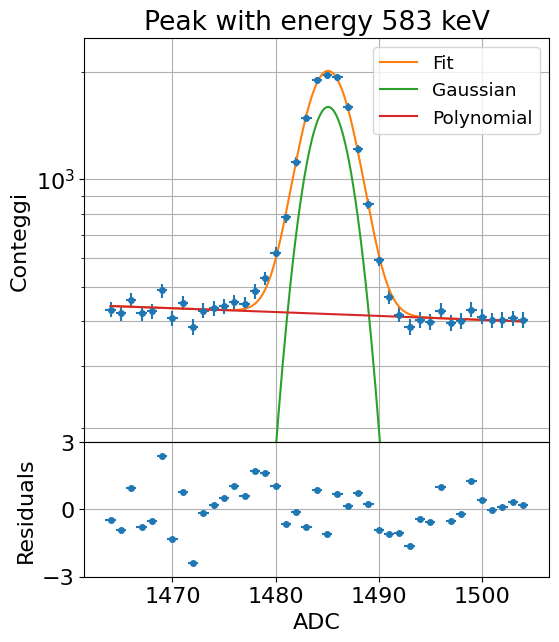

In [31]:
i = 1
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 609 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.25 (χ²/ndof = 1.1)      │              Nfcn = 399              │
│ EDM = 3.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

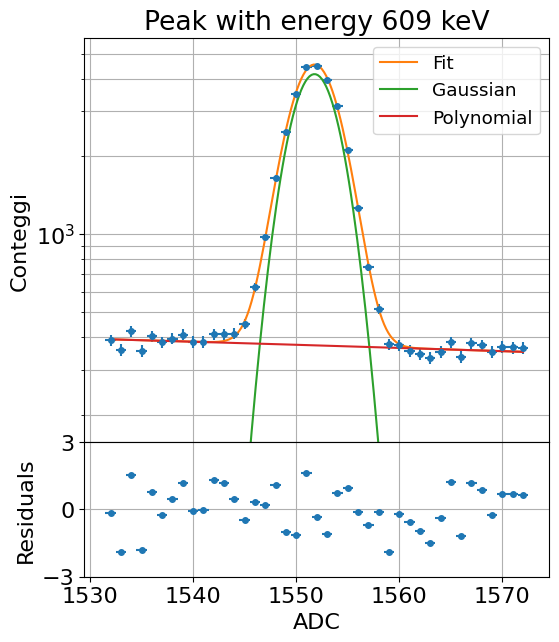

In [32]:
i = 2
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 1460 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.97 (χ²/ndof = 1.2)      │              Nfcn = 578              │
│ EDM = 2.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬─────────

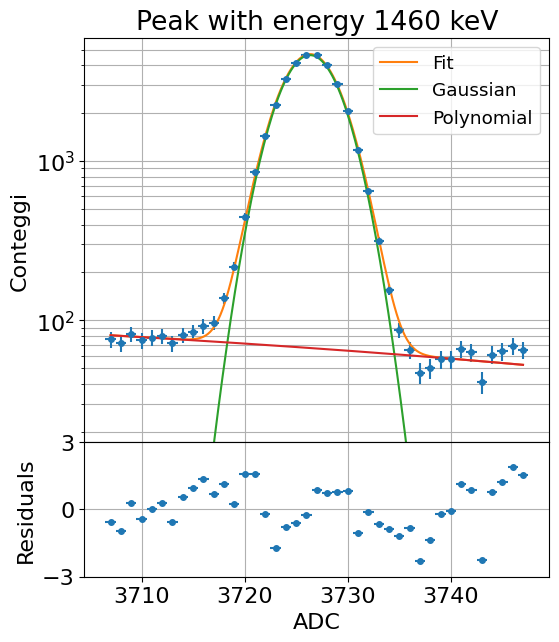

In [33]:
i = 3
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 2615 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.3 (χ²/ndof = 1.2)       │              Nfcn = 724              │
│ EDM = 5.69e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬─────────

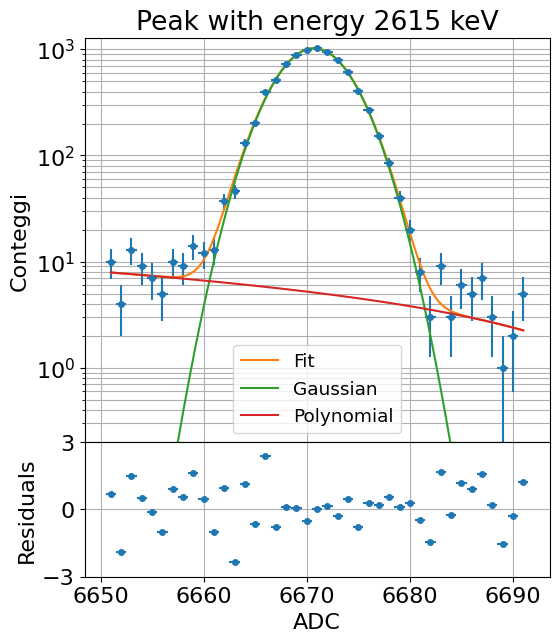

In [34]:
i = 4
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

In [35]:
adc_peaks, adc_peaks_err

(array([ 896.19145907, 1485.09570489, 1551.77406632, 3726.34408178,
        6670.70814126]),
 array([0.02078325, 0.03537868, 0.01842869, 0.01646351, 0.03640407]))

In [38]:
def linear(x, p0, p1):
  return p0 + p1*x

lsq = LeastSquares(x=energy_peaks, y=adc_peaks, yerror = 1, model = linear)
m = Minuit(lsq, p0 = 0, p1 = 1)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.857 (χ²/ndof = 2.3)      │              Nfcn = 58               │
│ EDM = 2.25e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   -2.4    │    0.8    │            │            │         │         │       │
│ 1 │ p1   │  2.5525   │  0.0005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │      0.562 -322.39e-6 │
│ p1 │ -322.39e-6   2.87e-07 │
└────┴───────────────────────┘

In [40]:
def quadratic(x, p0, p1, p2):
  return p0 + p1*x + p2*x**2

lsq = LeastSquares(x=energy_peaks, y=adc_peaks, yerror = 1, model = quadratic)
m = Minuit(lsq, p0 = 0, p1 = 1, p2 = 0.1)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.563 (χ²/ndof = 1.8)      │              Nfcn = 103              │
│ EDM = 8.59e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   -4.8    │    1.5    │            │            │         │         │       │
│ 1 │ p1   │  2.5577   │  0.0029   │            │            │         │         │       │
│ 2 │ p2   │  -1.7e-6  │  1.0e-6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────┐
│    │           p0           p1           p2 │
├────┼────────────────────────────────────────┤
│ p0 │         2.35    -4.149e-3 1.2790487e-6 │
│ p1 │    -4.149e-3     8.46e-06   -2.7300e-9 │
│ p2 │ 1.2790487e-6   -2.7300e-9     9.12e-13 │
└────┴────────────────────────────────────────┘

(6661.0, 6681.0)

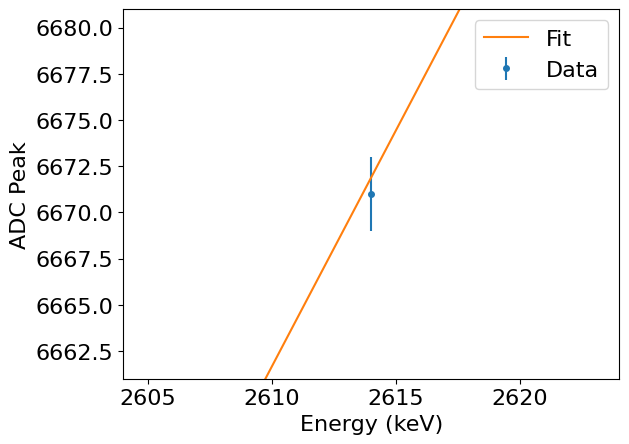

In [ ]:
plt.errorbar(energy_peaks, adc_peaks, yerr = adc_peaks_err, ls = "None", marker = "o", ms = 4, label = "Data")
x = np.linspace(0, 2700)
y = linear(x, *m.values)
plt.plot(x, y, label = "Fit")
plt.xlabel("Energy (keV)")
plt.ylabel("ADC Peak")
plt.legend();

# Zoom sui primi due picchi
plt.xlim(570, 620)
plt.ylim(1460, 1560)

#
plt.xlim(1460 -10, 1460 +10)
plt.ylim(3727 -10, 3727 +10)

plt.xlim(2614 -10, 2614 +10)
plt.ylim(6671 -10, 6671 +10)